In [6]:
!pip -q install "qiskit>=1.1" "qiskit-aer>=0.14" matplotlib
!pip install pylatexenc

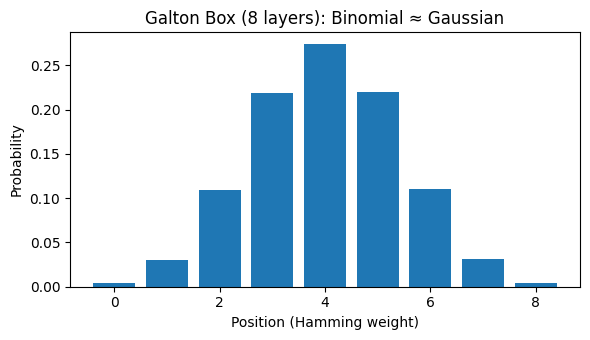

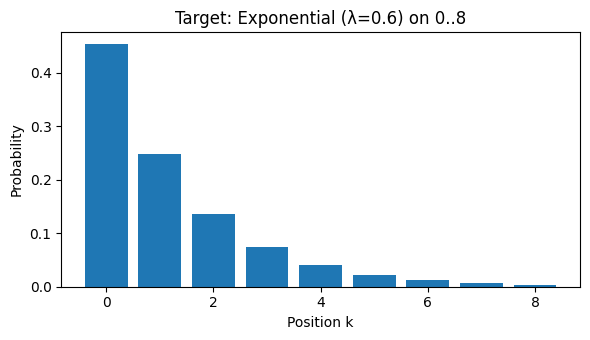

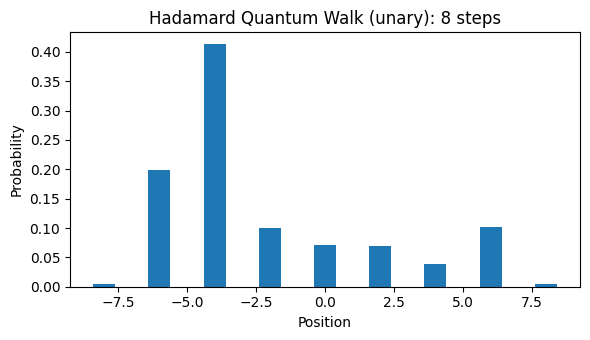

(array([-8, -7, -6, -5, -4, -3, -2, -1,  0,  1,  2,  3,  4,  5,  6,  7,  8]),
 array([0.00432, 0.     , 0.19884, 0.     , 0.4128 , 0.     , 0.09926,
        0.     , 0.07032, 0.     , 0.07018, 0.     , 0.03814, 0.     ,
        0.10176, 0.     , 0.00438]))

In [8]:
# QGB + targets (Qiskit ≥1.1, Aer ≥0.14)
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.quantum_info import Statevector
from qiskit_aer import AerSimulator
import numpy as np
import math
import matplotlib.pyplot as plt
from collections import Counter

sim = AerSimulator(method="statevector")

# ---------- (2) n-layer Galton box -> Gaussian (binomial) ----------
def galton_box_gaussian(n: int, shots: int = 50_000):
    """
    Use n independent Hadamard 'coins'. Measurement bitstrings are binned
    by Hamming weight (i.e., number of '1's) -> Binomial(n, 1/2) ≈ Gaussian.
    """
    q = QuantumRegister(n, "coin")
    c = ClassicalRegister(n, "c")
    qc = QuantumCircuit(q, c, name=f"QGB_{n}")
    for i in range(n):
        qc.h(q[i])
    qc.measure(q, c)

    job = sim.run(qc, shots=shots)
    counts = job.result().get_counts()

    # bin by Hamming weight
    weight_hist = Counter()
    for bitstr, ct in counts.items():
        k = bitstr.count("1")
        weight_hist[k] += ct

    # normalize
    xs = list(range(n+1))
    ys = np.array([weight_hist.get(k, 0) for k in xs], dtype=float)
    ys /= ys.sum()

    # plot
    plt.figure(figsize=(6,3.5))
    plt.bar(xs, ys)
    plt.title(f"Galton Box ({n} layers): Binomial ≈ Gaussian")
    plt.xlabel("Position (Hamming weight)")
    plt.ylabel("Probability")
    plt.tight_layout()
    plt.show()
    return xs, ys


# ---------- FIXED (3a) Exponential target (noiseless all-to-all) ----------
def exponential_sampler(n_layers: int, lam: float = 0.6):
    """
    Build the exact target distribution p_k ∝ e^{-λk} on k=0..n and plot it.
    (Direct state-prep is equivalent to a noiseless all-to-all sampler.)
    """
    n_bins = n_layers + 1
    p = np.exp(-lam * np.arange(n_bins))
    p = p / p.sum()

    xs = np.arange(n_bins)
    plt.figure(figsize=(6,3.5))
    plt.bar(xs, p)
    plt.title(f"Target: Exponential (λ={lam}) on 0..{n_layers}")
    plt.xlabel("Position k")
    plt.ylabel("Probability")
    plt.tight_layout()
    plt.show()
    return xs, p




# ---------- FIXED (3b) Hadamard quantum walk using UNARY position ----------
from qiskit.circuit.library import CSXGate

def hadamard_quantum_walk(n_steps: int, shots: int = 50_000):
    """
    1D coined Hadamard walk with unary position encoding.
    L = 2*n_steps + 1 position qubits; start with a single '1' at center.
    Shift left/right is a chain of CSWAPs controlled by the coin qubit.
    """
    L = 2*n_steps + 1
    pos = QuantumRegister(L, "x")    # unary position: exactly one |1>
    coin = QuantumRegister(1, "c")
    creg = ClassicalRegister(L, "m")
    qc = QuantumCircuit(coin, pos, creg, name=f"QW_unary_{n_steps}")

    # init: position at center (index n_steps), coin in |0>
    qc.x(pos[n_steps])

    # helper: controlled shift right (toward higher indices)
    def ctrl_shift_right(circ):
        # move the lone |1> one site to the right by cascading CSWAPs
        for j in reversed(range(L-1)):
            circ.cswap(coin[0], pos[j], pos[j+1])

    # helper: controlled shift left
    def ctrl_shift_left(circ):
        for j in range(L-1):
            circ.cswap(coin[0], pos[j], pos[j+1])

    # one step: H on coin, then conditional shifts:
    # shift-left if coin=|0>, shift-right if coin=|1>.
    for _ in range(n_steps):
        qc.h(coin)
        # implement: (|0><0|⊗Shift_L + |1><1|⊗Shift_R)
        # Shift left controlled on |0>  => flip control to use cswap(control on |1|):
        qc.x(coin)              # now control-on-1 acts as control-on-0
        ctrl_shift_left(qc)
        qc.x(coin)
        # Shift right controlled on |1>
        ctrl_shift_right(qc)

    # measure position distribution
    qc.measure(pos, creg)

    job = sim.run(qc, shots=shots)
    counts = job.result().get_counts()

    dist = np.zeros(L, dtype=float)
    for bitstr, ct in counts.items():
        # unary: the measured '1' location equals position index
        bits = bitstr.split()[-1] if isinstance(bitstr, str) else bitstr
        idx = bits[::-1].find("1")    # little-endian
        if idx != -1:
            dist[idx] += ct
    dist /= dist.sum()

    xs = np.arange(-n_steps, n_steps+1)
    plt.figure(figsize=(6,3.5))
    plt.bar(xs, dist)
    plt.title(f"Hadamard Quantum Walk (unary): {n_steps} steps")
    plt.xlabel("Position")
    plt.ylabel("Probability")
    plt.tight_layout()
    plt.show()
    return xs, dist




# --------- QUICK RUN EXAMPLES (change n as needed) ----------
n = 8  # layers/steps
galton_box_gaussian(n)
exponential_sampler(n, lam=0.6)
hadamard_quantum_walk(n_steps=n)
